In [1]:
import sys, os
import torch
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

import warnings; 
warnings.simplefilter('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE'
  warn(f"Failed to load image Python extension: {e}")


In [2]:
%reload_ext autoreload
%autoreload 2

In [7]:
COLAB = 'google.colab' in str(get_ipython())
COMPRESSED = False

'''
The pbz2 files below were read in and compressed and pickled using code
adapted from: https://benchmark.ini.rub.de/gtsrb_dataset.html#Codesnippets.
See utils/helpers.py file for details. 
'''
    
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    gdrive_path = '/content/drive//MyDrive/DL4CV-2022/GTSRB/project-I/'
    sys.path.append(gdrive_path)
    
    import utils.helpers as utils
    import loader.gtsrb_data as dataset

    if COMPRESSED:
        GTSRB_train_dataset = utils.decompress_pickle(gdrive_path + 'data/pbz2/GTSRB_train_dataset.pbz2') 
        GTSRB_train_dataloader = utils.decompress_pickle(gdrive_path + 'data/pbz2/GTSRB_train_dataloader.pbz2') 
    else:
        GTSRB_train_dataset = dataset.GTSRB(gdrive_path+'data/')
        GTSRB_train_dataloader = torch.utils.data.DataLoader(GTSRB_train_dataset, 
                                                  batch_size=128, 
                                                  shuffle=True, num_workers=2)
else:
    path = 'data'
    import utils.helpers as utils
    import loader.gtsrb_data as dataset

    if COMPRESSED:
        GTSRB_train_dataset = utils.decompress_pickle('data/pbz2/GTSRB_train_dataset.pbz2') 
        GTSRB_train_dataloader = utils.decompress_pickle('data/pbz2/GTSRB_train_dataloader.pbz2')
    else:
        GTSRB_train_dataset = dataset.GTSRB('data/')
        assert len(GTSRB_train_dataset) == 39209
        GTSRB_train_dataloader = torch.utils.data.DataLoader(GTSRB_train_dataset, 
                                                  batch_size=128, 
                                                  shuffle=True, num_workers=2)
    
#!ls $path

In [9]:
if COLAB:
    sign_names = utils.make_class_dict(gdrive_path + 'data/signnames.csv')
else:
    sign_names = utils.make_class_dict('data/signnames.csv')

classes = list(sign_names.values())

In [10]:
img, label, frame = GTSRB_train_dataset[0]
img_frame = list(frame.items())

In [11]:
img_frame[3][1]

25

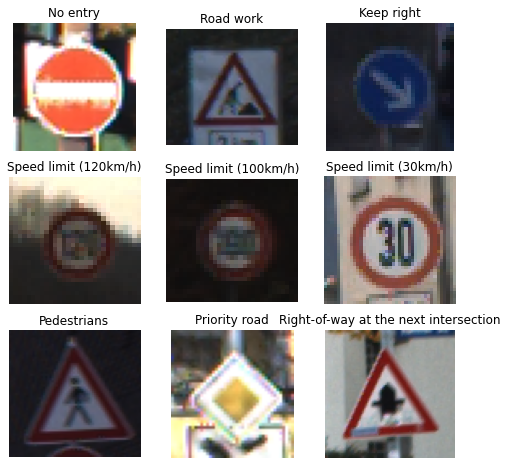

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(GTSRB_train_dataset), size=(1,)).item()
    img, label, frame = GTSRB_train_dataset[sample_idx]    
    figure.add_subplot(rows, cols, i)
    plt.title(sign_names[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
''' GUTTER

# for automatic reloading and inline matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#from sklearn.metrics import confusion_matrix

from PIL import Image

print (len(trainLabels), len(trainImages))


class GTSRBLoader(torch.utils.data.Dataset):

    def __init__(self, data_dir, split, custom_transforms=None, list_dir=None,
                 out_name=False,  crop_size=None, num_classes=43, phase=None):
        
        self.data_dir = data_dir
        self.split = split
        self.phase = split if phase is None else phase
        self.crop_size = 32 if crop_size is None else crop_size
        self.out_name = out_name
        self.idx2label = idx2label
        self.classnames = classnames

        self.num_classes = num_classes
        self.mean = np.array([0.3337, 0.3064, 0.3171])
        self.std = np.array([0.2672, 0.2564, 0.2629])
        self.image_list, self.label_list = None, None
        self.read_lists()
        self.transforms = self.get_transforms(custom_transforms)


    def __getitem__(self, index):
        im = Image.open(f'{self.data_dir}/{self.image_list[index]}')
        data = [self.transforms(im)]
        data.append(self.label_list[index])
        if self.out_name:
            data.append(self.image_list[index])
        return tuple(data)


    def __len__(self):
        return len(self.image_list)


    def get_transforms(self, custom_transforms):
        if custom_transforms:
            return custom_transforms

        if 'train' == self.phase:
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ]) 
        else: 
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ])   


    def read_lists(self):
        image_path = os.path.join(self.data_dir, self.split + '_images.txt')
        assert os.path.exists(image_path)
        self.image_list = [line.strip().split()[0] for line in open(image_path, 'r')]
        self.label_list = [int(line.strip().split()[1]) for line in open(image_path, 'r')]
        assert len(self.image_list) == len(self.label_list)

    
    # get raw image prior to normalization
    # expects input image as torch Tensor
    def unprocess_image(self, im, plot=False):
        im = im.squeeze().numpy().transpose((1, 2, 0))
        im = self.std * im + self.mean
        im = np.clip(im, 0, 1)
        im = im * 255
        im = Image.fromarray(im.astype(np.uint8))
        
        if plot:
            plt.imshow(im)
            plt.show()
        else:
            return im
  
    # de-center images and bring them back to their raw state
    def unprocess_batch(self, input):
        for i in range(input.size(1)):
            input[:,i,:,:] = self.std[i] * input[:,i,:,:]
            input[:,i,:,:] = input[:,i,:,:] + self.mean[i]
            input[:,i,:,:] = np.clip(input[:,i,:,:], 0, 1)

        return input
'''